# Presentation

In [1]:
using SARProcessing, Images, Statistics, SciPy, Plots, Dates

#### Define helper
First we create helper functions we will need for various things:

In [2]:
## small cheat function to easy load the test data 
const folder = "../test/testData/largeFiles/EO_workshop_full/"

const orbit_path = [
    "S1A_OPER_AUX_POEORB_OPOD_20210330T183728_V20190621T225942_20190623T005942.EOF",
    "S1B_OPER_AUX_POEORB_OPOD_20210330T202915_V20190627T225942_20190629T005942.EOF",
    "S1A_OPER_AUX_POEORB_OPOD_20210330T223401_V20190703T225942_20190705T005942.EOF",
    "S1B_OPER_AUX_POEORB_OPOD_20210331T002809_V20190709T225942_20190711T005942.EOF"
    ]


const image_list = [
    "S1A_IW_SLC__1SDV_20190622T015048_20190622T015115_027786_0322F1_7A8E.SAFE",
    "S1B_IW_SLC__1SDV_20190628T014958_20190628T015025_016890_01FC87_FC0D.SAFE",
    "S1A_IW_SLC__1SDV_20190704T015049_20190704T015116_027961_03283A_191E.SAFE",
    "S1B_IW_SLC__1SDV_20190710T014959_20190710T015026_017065_0201B8_069B.SAFE"
    ]

#= # Load workshop related data (very hardcoded)
function load_test_slc_image(folder, image_number)
    tiffs = ["S1A_IW_SLC__1SDV_20190622T015048.tiff","S1B_IW_SLC__1SDV_20190628T014958.tiff",
     "S1A_IW_SLC__1SDV_20190704T015049.tiff", "S1B_IW_SLC__1SDV_20190710T014959.tiff" ]
    annotation_files = ["s1a-iw2-slc-vv-20190622t015048-20190622t015113-027786-0322f1-005.xml",
    "s1b-iw2-slc-vv-20190628t014958-20190628t015023-016890-01fc87-005.xml",
     "s1a-iw2-slc-vv-20190704t015049-20190704t015114-027961-03283a-005.xml",
     "s1b-iw2-slc-vv-20190710t014959-20190710t015024-017065-0201b8-005.xml"]

    tiff_file = tiffs[image_number]
    is_S1A = split(tiff_file,"_")[1] == "S1A"

    window = is_S1A ? [[100 , 1500],[7600 , 20000]] : [[3*1506 , 3*1506+1600],[7500 , 20100]]

    metadata = SARProcessing.Sentinel1MetaData(joinpath(folder, annotation_files[image_number]))
    index_start = (window[1][1],window[2][1])
    data = SARProcessing.load_tiff(joinpath(folder, tiff_file))

    return SARProcessing.Sentinel1SLC(metadata,index_start,data,false)
end =#

# Additinal plotting function, not yet implemented in the SARProcessing.jl package
function plot_multiple_sar(rgb_data; p_quantile = 0.85)
    scaled_data = [ abs2.(data) for data in rgb_data]
    min_value = minimum(reshape(scaled_data[1],:))
    factor = quantile(reshape(scaled_data[1],:),p_quantile) - min_value

    scaled_data = [ (data .- min_value) ./ factor for data in scaled_data]

    img =[Images.Colors.RGB(scaled_data[1][i,j],scaled_data[2][i,j],scaled_data[3][i,j]) 
        for i=1:size(scaled_data[1])[1], j=1:size(scaled_data[1])[2]]
    return img
end

# Additinal plotting function, not yet implemented in the SARProcessing.jl package
function plot_phase(img)
    phase = (angle.(img) .+pi)./(2*pi)

    return Images.Colors.RGB{Float32}.(1 .-phase.^2,4 .*(phase .-  phase.^2),phase.^2)
end

# Additinal coherence estimation function, not yet implemented in the SARProcessing.jl package
function complex_coherence(master, slave, flat, kernel)
    # Define relevant image signals
    signal_1 = master .* conj.(slave) .* flat
    signal_2 = abs2.(master)
    signal_3 = abs2.(slave)
    kernel_1 = convert.(eltype(signal_1),kernel)
    kernel_2 = convert.(eltype(signal_2),kernel)
    kernel_3 = convert.(eltype(signal_3),kernel)

    # Compute real and imaginary parts seperately
    interferogram =  SARProcessing.fastconv(signal_1, kernel_1)
    master_intensity = SARProcessing.fastconv(signal_2, kernel_2)
    slave_intensity = SARProcessing.fastconv(signal_3, kernel_3)

    # Compute the complex coherence
    complex_coherence = interferogram ./ (sqrt.(master_intensity .* slave_intensity));

    return complex_coherence
end;


function get_burst_window(metadata,burst_number) 
    burst_number = 7
    window = [[(metadata.swath.lines_per_burst*(burst_number-1)+1),
    metadata.swath.lines_per_burst*burst_number],[1,metadata.swath.samples_per_burst]]
return window 

ErrorException: syntax: incomplete: "function" at /Users/lupemba/Documents/git repos/SARProcessing.jl/juliaEO2023/4_insar.ipynb:82 requires end

### Load and visualize a SAR image

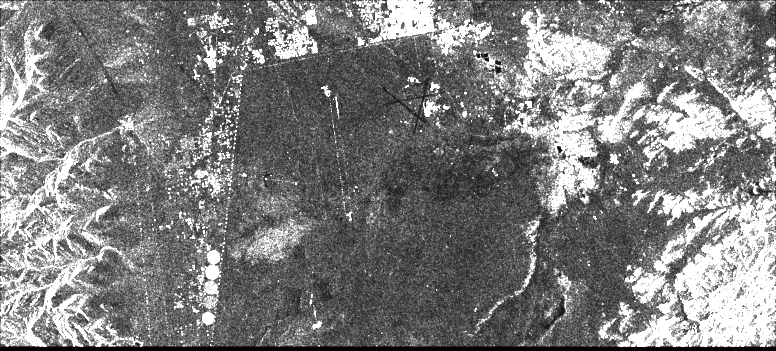

In [3]:
swath = 2 
polarisation = SARProcessing.VV
file_path = joinpath(folder,image_list[1])
sar_image = SARProcessing.load_sentinel1_slc(file_path,polarisation,swath,[[100 , 1500],[7600 , 20000]])
SARProcessing.sar2gray(sar_image.data[:,1:4:end])

This is an image of an area in California, you can notice mountainous areas in the sides and in the middle you can see fields and so on.


## Geocoding
Initially we want to show the process of connecting specific pixels in the SLC data (above) to actual coordinates on ground. This is mainly covered by backend functions in the SARProcessing.jl package but we will see in what order you need to call them for the process of going from SLC -> Interferograms

### Load orbit file and create interpolator
We start by loading the orbit file that covers the time of the data acquisition. Orbit files consists of time, position and velocity of the satellite.

In [4]:
orbit_sate_file_path = joinpath(folder, orbit_path[1]);
orbit_states =  SARProcessing.load_precise_orbit_sentinel1(orbit_sate_file_path);

orbit_states[1].time, orbit_states[1].position,orbit_states[1].velocity 

(DateTime("2019-06-21T22:59:42"), [-1.962909282656e6, 4.300927106914e6, 5.255246445313e6], [-499.857794, 5774.883891, -4900.74554])

We need to have the orbit defined for whole time interval of the SLC acquisition. In order to create an orbit interpolator we can use the package:

In [6]:
orbit_interpolator = SARProcessing.orbit_state_interpolator(orbit_states,sar_image.metadata);

The orbit state does not vary a lot throughout the image, but here is a visualisation for how the velocity varies in the z direction. 

NOTE: we have the times as float values from a reference time because of the need to have milisecond accuracy, we are thinking of better ways to do this.

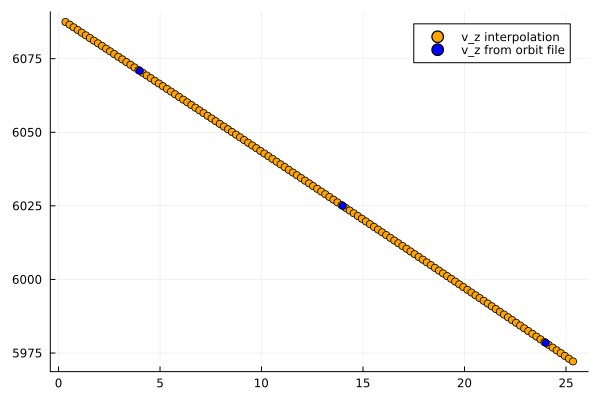

In [7]:

vz_states = [ element.velocity[3] for element in orbit_states]
t_s_states = [ Dates.value.(element.time-sar_image.metadata.reference_time) / 1000 for element in orbit_states] 

image_start = sar_image.metadata.header.start_time
image_stop = sar_image.metadata.header.stop_time

in_image = ((sar_image.metadata.header.start_time -1) .< t_s_states) .& (t_s_states  .< (sar_image.metadata.header.stop_time +1))

t_interpolation = collect(image_start:0.2:image_stop)
vz_interpolation = [orbit_interpolator(t).velocity[3] for t in t_interpolation]

p=scatter(t_interpolation , vz_interpolation, label="v_z interpolation", color="orange")
scatter!(t_s_states[in_image],vz_states[in_image], label="v_z from orbit file", color="blue")


### Geolocate the air strip in the picture
This is an example of an airstrip that you can find in the image.

In [8]:
img = SARProcessing.sar2gray(sar_image.data);

In [9]:
offset = (sar_image.index_start[1] -1, sar_image.index_start[2]-1)

(99, 7599)

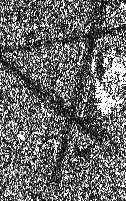

In [10]:
SARProcessing.sar2gray(sar_image.data[(450-offset[1]):(650-offset[1]),(14000-offset[2]):4:(14500-offset[2])])

In [11]:
point = (567 ,14288)

(567, 14288)

The coordinates of the airstrip is approximately at index-coordinates (450, 6500), now we will find out what the correspond to in (lat, lon)

You can check the the coordinates works, by checking them on google maps (click the link or copy paste):

The function `sar_index2geodetic()` works by transforming the index to a azimuth time of the satellite and a range. Hereafter it solves three non-linear equations to find the point. The equations that are being solve, states:
- Line of sight is perpendicular to the satellite velocity
- The distance to the point matches the range
- The point is at the input height above the ellipsoid (here we just guessed the height to be 10)

There is also a function to go the other way: from index (row, col) to a (lat, lon) coordinate

The function `geodetic2SAR_index()` works by calculate the satellite position based on a given time (an initial guess). Then the angle between the satellite velocity and the SAR line-of-sight is computed to evaluate if the point is in front or behind satellite at the given time. The time guess is then adjusted until the line-of-sight is perpendicular to the veloicty. This gives the azimuth time, corresponding to the row in the image. The range, which corresponds to the column in the image, is calculated as the distance between the satellite position and the point.

### Use a digital elevation model to get the heights for the pixel in the SAR image
Instead of guessing the height a much more qualified model is to use a digital elevation model. The model is given in (lat, lon) coordinates, so the first step we need to consider is to convert the height coordinates into SAR indeces. Hereafter we can interpolate the heights to the desired locations in SAR geometry.

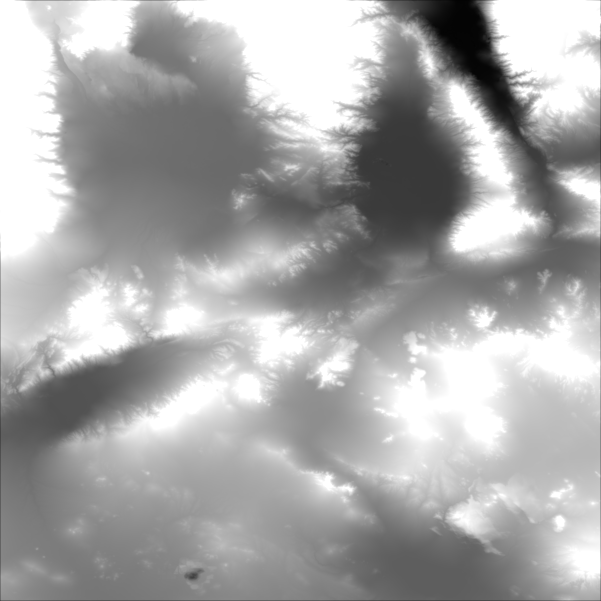

In [13]:
#dem = SARProcessing.load_tandemx_dem(folder*"dem_re2.tif");
dem = SARProcessing.load_tandemx_dem(folder*"TDM1_DEM__30_N35W118_V01_C/DEM/TDM1_DEM__30_N35W118_DEM.tif");

#gdalwarp -s_srs "+proj=longlat +datum=WGS84 +no_defs +geoidgrids=egm96_15.gtx" -t_srs "+proj=longlat +datum=WGS84 +no_def" TDM1_DEM__30_N35W118_DEM.tif dem_re2.tif
SARProcessing.sar2gray(dem.heights)

Now we will just preprocess the DEM data a little:

In [14]:
# helper function to convert latitude and longitude to radians for the DEM heights
dem_geodetic_coordinates = 
[  [ (SARProcessing.get_coordinate(dem,(i,j)) .* (pi/180))...,dem.heights[i,j]] for i=1:size(dem.heights)[1], j=1:size(dem.heights)[2]];


In [15]:
# filter the dem to only the heights in the image
dem_geodetic_coordinates = reshape(dem_geodetic_coordinates,:);

# find the part of the DEM which overlaps with the satellite acquisition
dem_in_image = [ 
    SARProcessing.is_coordinate_in_time_range(SARProcessing.geodetic2ecef(coord)
    ,SARProcessing.get_time_range(sar_image.metadata),orbit_interpolator) 
    for coord in dem_geodetic_coordinates] 

# crop the DEM, so we only get the area of interest
dem_geodetic_coordinates = dem_geodetic_coordinates[dem_in_image];

Now we transform the the coordinates of the DEM to SAR indeces.

In [16]:
## Get the location of the heights in the SAR image 
dem_sar_index = 
[ [SARProcessing.geodetic2SAR_index(coords, orbit_interpolator, sar_image.metadata,1)...] 
    for coords in dem_geodetic_coordinates];

# unpack the heights that match
heights = [coords[3] for coords in dem_geodetic_coordinates]

## clean up variables
dem_geodetic_coordinates =nothing
dem_in_image = nothing
dem = nothing


We do not need to compute the height for every single pixel, we can get away with subsampling. So instead we create a grid in the SAR geometry, which is only sampling every 10th row and every 40th column (you can try to vary this if you want)

In [20]:
## Create a grid in the SAR image.
# It is not necessary to interpolate the heights for every pixel, just a grid

rows_range = sar_image.index_start[1] : (sar_image.index_start[1] + size(sar_image.data)[1]-1)
columns_range = sar_image.index_start[2]  : (sar_image.index_start[2] + size(sar_image.data)[2]-1)

rows = collect( rows_range.start:10:rows_range.stop)
columns =  collect( columns_range.start:40:columns_range.stop)

rows_grid = ones(length(columns))' .* rows
columns_grid = columns' .* ones(length(rows));


Now we are able to interpolate the heights to the grid, and we are using SciPy.interpolate.griddata because the dem_sar_index are unstructured in SAR geometry (not on a grid). 

In [21]:
point

(567, 14288)

In [22]:
## interpolate the heights to the sar idex grid
point_height = SciPy.interpolate.griddata(
    hcat(dem_sar_index...)',heights, (point[1:1], point[2:2]) )

1-element Vector{Float64}:
 643.9073657109778

In [35]:
coordinates_air_strip = SARProcessing.sar_index2geodetic(point... ,
point_height[1],orbit_interpolator,sar_image.metadata,1)

coordinates_air_strip[1:2] .*180/pi

2-element Vector{Float64}:
   35.692810468927576
 -117.68938725600444

https://www.google.com/maps/@35.692060989571274,-117.68961903325344,48m/data=!3m1!1e3

In [36]:

expected = [35.6925994*pi/180,-117.6895281*pi/180,643]

dif = (coordinates_air_strip[1:2] .- expected[1:2] ).*180/pi

2-element Vector{Float64}:
 0.0002110689275762409
 0.00014084399554627726

In [37]:
dif[1] * pi/180 * 6371.000  , dif[2] * pi/180 * (6371.000*cos(expected[1]))

(0.023469793918785786, 0.012719332302594148)

In [38]:
point_computed = SARProcessing.geodetic2SAR_index(expected,orbit_interpolator,sar_image.metadata,1) 

point.-point_computed

(1.4968143051872858, 4.268356273138124)

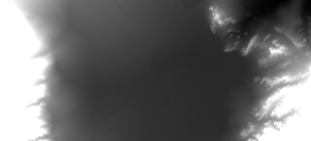

In [39]:
## interpolate the heights to the sar idex grid
interpolated_heights = SciPy.interpolate.griddata(
    hcat(dem_sar_index...)',heights, (reshape(rows_grid,:), reshape(columns_grid,:)) )


interpolated_heights = reshape(interpolated_heights,size(rows_grid))

SARProcessing.sar2gray(interpolated_heights)


How does this look similar to the SAR image in the beginning of the notebook?

### Convert the SAR grid to (lat, lon) - coordinates
Now we can convert the SAR index grid that we defined to (lat, lon) coordinates using the interpolated heights, such that we are able to know where this grid is with respect to another SAR image. This can also be used to resample the SAR image data itself to a regular coordinate grid (this is not recommended for a InSAR processing chain, because it introduces an additional error term).

In [41]:
sar_grid_coordinate = [SARProcessing.sar_index2geodetic(rows[i], columns[j] ,interpolated_heights[i,j],
                orbit_interpolator,
                sar_image.metadata,1) for i=1:length(rows), j=1:length(columns) ];

## print some coordinate to show
[[sar_grid_coordinate[i,j][1:2] .*180 ./pi,sar_grid_coordinate[i,j][3]] for i = 10:13, j=10:11 ]

4×2 Matrix{Vector{Any}}:
 [[35.6102, -117.928], 1070.33]  [[35.6105, -117.926], 1067.96]
 [[35.6115, -117.928], 1081.15]  [[35.6117, -117.926], 1075.83]
 [[35.6128, -117.928], 1090.05]  [[35.613, -117.927], 1079.19]
 [[35.614, -117.928], 1096.17]   [[35.6142, -117.927], 1080.52]

Every element above is ordered lik [lat, lon, height], and it is clear the a height of 10 meters was a pretty bad guess.

## Handling the secondary SAR image
In order to compute the InSAR we need 2 SAR images, so we will now describe how we handle the secondary image. We refer to the first SAR image as the "primary" image and the second one as the "secondary" images (also known as the "master" and "slave" image).

Below you can see that we have prepared a subset of the secondary image, which approximately overlaps the data in the primary image.

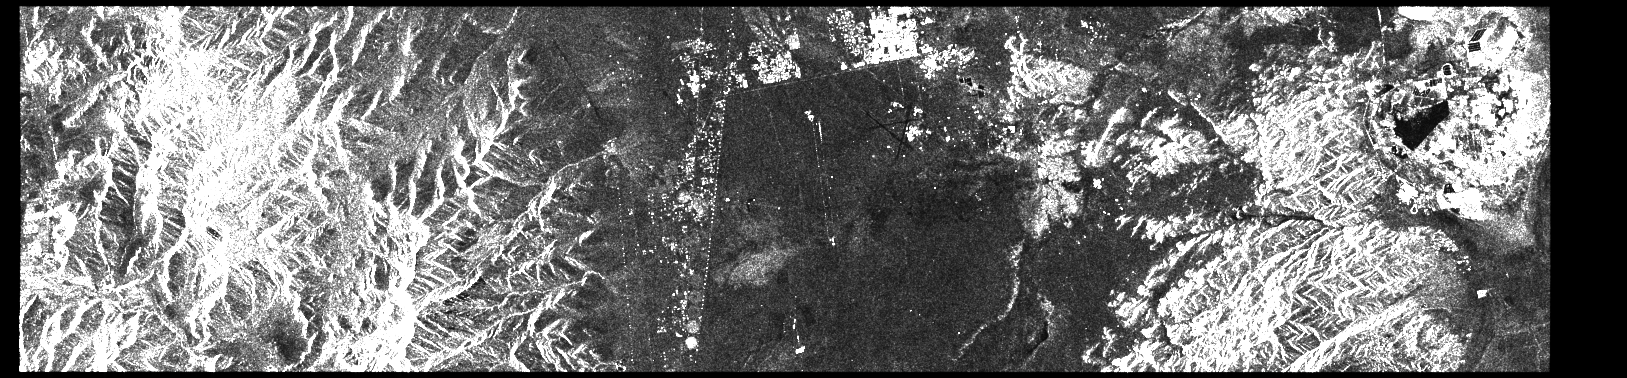

In [45]:
file_path = joinpath(folder,image_list[2])
secondary_sar_image = SARProcessing.load_sentinel1_slc(file_path,polarisation,swath,4)
SARProcessing.sar2gray(secondary_sar_image.data[:,1:4:end])

As before we create an orbit interpolator:

In [46]:
## create an orbit interpolator for the second image
orbit_sate_file_path2 = joinpath(folder,orbit_path[2]);
orbit_interpolator2 = SARProcessing.orbit_state_interpolator(
    SARProcessing.load_precise_orbit_sentinel1(orbit_sate_file_path2),
    secondary_sar_image.metadata);


Now we compute the positions in the secondary image corresponding to the grid we defined in the primary image 

In [48]:
# get the grid in image two indecies
grid_image2 =
    [ [SARProcessing.geodetic2SAR_index(coords, orbit_interpolator2, secondary_sar_image.metadata,4)...] 
        for coords in sar_grid_coordinate];
    
    
grid_image2[10:13,10:13]

4×4 Matrix{Vector{Float64}}:
 [189.574, 8089.17]  [189.574, 8129.18]  …  [189.575, 8209.18]
 [199.574, 8089.17]  [199.575, 8129.18]     [199.575, 8209.18]
 [209.574, 8089.17]  [209.574, 8129.18]     [209.575, 8209.18]
 [219.574, 8089.17]  [219.575, 8129.18]     [219.575, 8209.18]

Here is an example of how a grid point in the primary image is located in the secondary image.

In [49]:
(rows[10],columns[13]), grid_image2[10,13]

((190, 8080), [189.5746187102761, 8209.178882404938])

The image rows are here a bit confusing. The row is counted as the number of unique rows from the first row in the entire Sentinel 1 swath for each image. It is necessary to adjust for the subset index offset and the burst overlap to get the actual row number in the data matrix. We hope to make this more simple in the future by restructuring the data struct and by using the OffsetArrays package. 
We did not do this in the primary image, as we were working with the first burst! But in the secondary image we need to find this offset, and correct correspondingly.

### Deramping
The way that Sentinel-1 steers its' antenna during acquisition gives rise to a phase ramp. We need to correct for the phase ramp before resampling the image, to avoid unwanted spectral artifacts. The details of this process are a bit involved, but we can simply call the `phase_ramp()` function to get the phase ramp, and remove it.

In [54]:
## deramp the data before resampling
rows_range2 = secondary_sar_image.index_start[1]:(secondary_sar_image.index_start[1] + size(secondary_sar_image.data)[1]-1)
burst_row_range2 = 1:size(secondary_sar_image.data)[1]
columns_range2 = secondary_sar_image.index_start[2]:(secondary_sar_image.index_start[2] + size(secondary_sar_image.data)[2]-1)
if !secondary_sar_image.deramped
    println("Deramping")

    mid_burst_state2 = SARProcessing.get_burst_mid_states(secondary_sar_image, orbit_interpolator2)
    mid_burst_state2 = mid_burst_state2[SARProcessing.get_burst_numbers(secondary_sar_image) .==4]
    mid_burst_speed2 = SARProcessing.get_speed.(mid_burst_state2)[1]

    phase_ramp2 = SARProcessing.phase_ramp(
        collect(rows_range2), 
        collect(columns_range2), 
    4, mid_burst_speed2, secondary_sar_image.metadata)


    secondary_sar_image.data .= secondary_sar_image.data .* exp.(-phase_ramp2 .* im)
    secondary_sar_image.deramped = true;
end;

### Resample the secondary image to the primary image
Here we create the interpolator to resample the secondary image to the primary image geometry using our knowledge about the grid locations

In [64]:
# create interpolators
image2_row_interpolator = SciPy.interpolate.interp2d(
    columns,rows,[index[1] for index in grid_image2])

image2_column_interpolator = SciPy.interpolate.interp2d(
        columns,rows,[index[2] for index in grid_image2])

rows_target2 = reshape(image2_row_interpolator(
    collect(columns_range),
    collect(rows_range)),:)

columns_target2 = reshape(image2_column_interpolator(
    collect(columns_range),
    collect(rows_range)),:)

image2_data_interpolator = SciPy.interpolate.RegularGridInterpolator(
    (collect( burst_row_range2),
    collect( columns_range2)),
    secondary_sar_image.data, bounds_error=false, fill_value=zero(eltype(secondary_sar_image.data)));

In [66]:
(sum((burst_row_range2.start .< rows_target2) .&  (rows_target2 .< burst_row_range2.stop)),
sum((columns_range.start .< columns_target2) .&  (columns_target2 .< columns_range.stop)))

(17373801, 17191671)

Here we resample the image and plot it, it can takes a minute

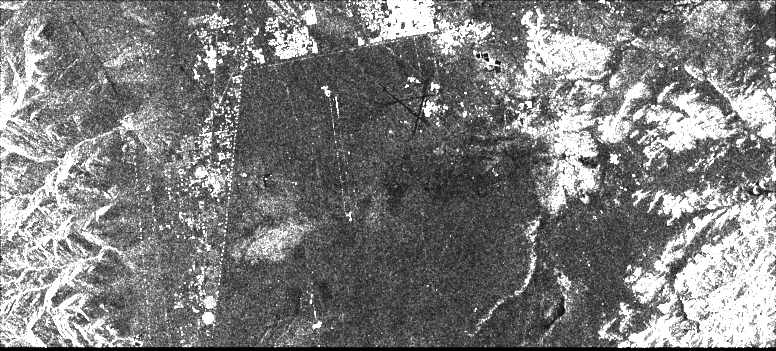

In [67]:
resampled_data = image2_data_interpolator(
    [
        [rows_target2[i],columns_target2[i]] 
        for i =1:length(columns_target2)
    ]
    )


resampled_data = reshape(resampled_data,size(sar_image.data));

SARProcessing.sar2gray(resampled_data[:,1:4:end])

We can plot the images on top of each other, assigning the red color to the secondary image and the blue+green to the primary image:

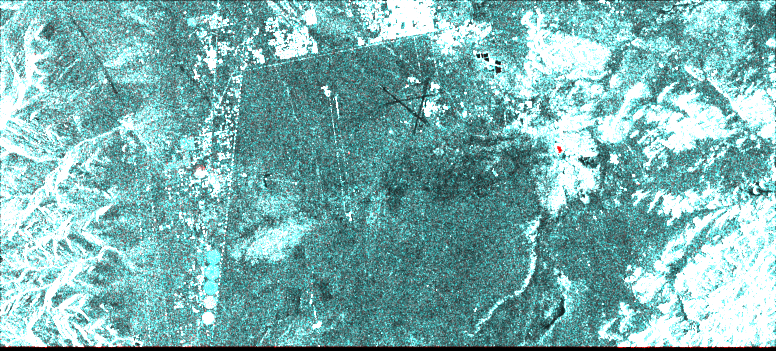

In [68]:
plot_multiple_sar([resampled_data[:,1:4:end],sar_image.data[:,1:4:end],sar_image.data[:,1:4:end]])

How do you intepret this image?

## Create Interferogram

### Reramp
Now we add the ramp from the primary image to the deramped secondary resampled image, to be able to use the phase difference.

In [69]:
## reramp the resampled image

mid_burst_state1 = SARProcessing.get_burst_mid_states(sar_image, orbit_interpolator)
mid_burst_state1 = mid_burst_state1[SARProcessing.get_burst_numbers(sar_image) .==1]
mid_burst_speed1 = SARProcessing.get_speed.(mid_burst_state1)[1]

phase_ramp1 = SARProcessing.phase_ramp(
    collect(rows_range), 
    collect(columns_range), 
1, mid_burst_speed1, sar_image.metadata)


resampled_data .= resampled_data .* exp.(phase_ramp1 .* im);

### Compute the flat interferogram
We now need to compute the phase changes that we would expect just from the different positions of the satellites alone. We do this so we can remove this part of the signal from the interferogram.

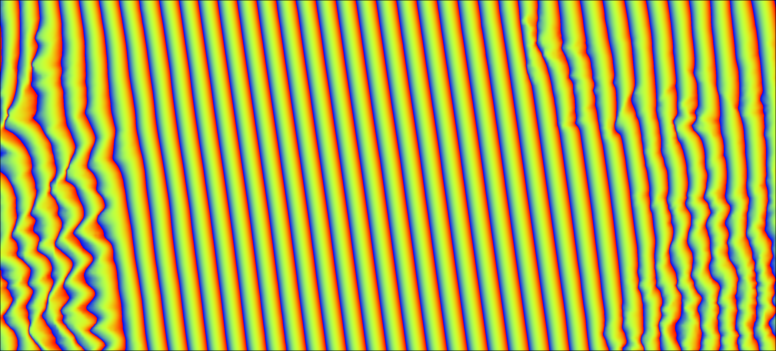

In [70]:
delta_r = (collect(columns_range)' .* ones(length(rows_range))) .- reshape(columns_target2,size(sar_image.data));
delta_r *= SARProcessing.get_range_pixel_spacing(sar_image.metadata);

lambda =  SARProcessing.LIGHT_SPEED/sar_image.metadata.product.radar_frequency

flat_interferogram = exp.(4*pi.*delta_r./lambda.*im);
plot_phase(flat_interferogram[:,1:4:end])

We are now ready to compute the interferogram.

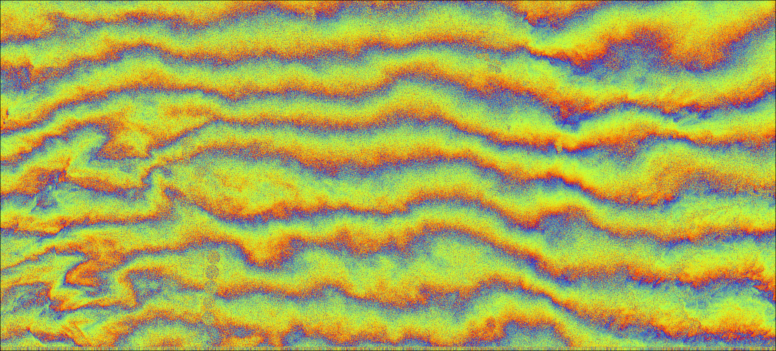

In [71]:
plot_phase((sar_image.data .* conj.(resampled_data) .*flat_interferogram)[:,1:4:end] )

It looks pretty but it is wrong... 
The number of phase fringes acoress this image indicates that there is an error in the azimuth direction of arround 1 pixel in the coregistration (we computed this elsewhere). You can still see the circular fields, which are areas of low phase coherence - this is a good sign. 

We can still compute the InSAR coherence (although underestimated due to the error), which you can see below:

In [72]:
kernel = ones(4,14)
coherence =  complex_coherence(sar_image.data, resampled_data,flat_interferogram, kernel);

#### Coherence

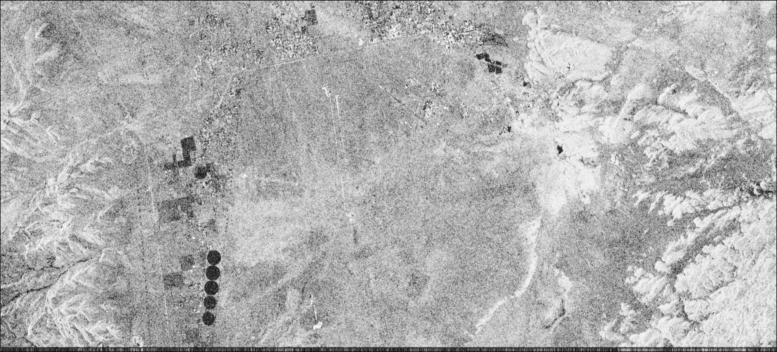

In [73]:
Images.Gray.(abs.(coherence[:,1:4:end]))

#### Coherence phase
The coherence phase is a filtered version of phase shown above. 

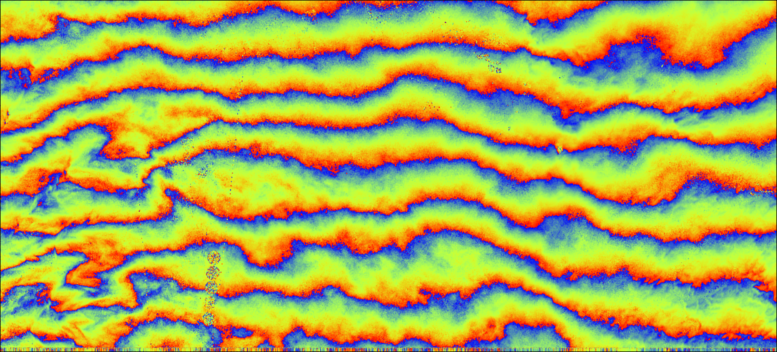

In [74]:
plot_phase(coherence[:,1:4:end])